# Trabajo Práctico 1: Reservas de Hotel - CHP2
## Grupo 05 - Medialunas 🥐

### Integrantes:
| Integrante                              | Número de Padrón |
|----------------------------------------|------------------|
| Iara Elizabeth Jolodovsky      | 109385           |
| Tomas Vainstein Aranguren      | 109043           |
| Martin Abramovich              | 108762           |

## Librerias

In [ ]:
!pip install 'dtreeviz'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 1.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import pickle
import numpy as np
import calendar
import sklearn as sk
import scipy.stats as st
from scipy import stats
from scipy import linalg
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

#Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz

#modelos y métricas
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, precision_recall_curve, roc_curve, make_scorer
from sklearn.metrics import confusion_matrix, classification_report

##arboles
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, GridSearchCV

#preprocesamiento
from sklearn.preprocessing import MinMaxScaler

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings('always')

## Funciones

In [ ]:
def calculate_mahalanobis_distance(dataset, col1, col2):
    X = dataset[[f'{col1}', f'{col2}']].copy()
    sample_X = X.sample(frac=0.1)

    mu = sample_X.mean()
    X_diff = X - mu
    X_diff = X_diff.values.T

    cov = np.cov(sample_X.values.T)
    inv_cov = np.linalg.inv(cov)
    W = linalg.sqrtm(inv_cov)

    Wx = np.matmul(W, X_diff)
    X['mahalanobis'] = [np.dot(Wx[:, i], Wx[:, i]) for i in range(Wx.shape[1])]

    return X

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


**Cargamos el dataset de hotels train ya procesado en el CHP1 y el dataset hotels_test el cual debemos preprocesar igual que el train**

In [ ]:
ds_hotels_train = pd.read_csv('./df_final_chp1.csv')
ds_training = ds_hotels_train.copy(deep=True)
ds_training['arrival_date'] = pd.to_datetime(ds_training['arrival_date'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [ ]:
ds_hotels_test = pd.read_csv('./hotels_test.csv')
ds_testing_conId = ds_hotels_test.copy(deep=True)
ds_testing_conId.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


(26535, 31)

Concatenamos arrival_date_year, arrival_date_month y arrival_date_day_of_month y unificamos en una variable arrival_date

In [ ]:
ds_testing_conId['arrival_date'] = ds_testing_conId['arrival_date_year'].astype(str) + '-' + ds_testing_conId['arrival_date_month'] + '-' + ds_testing_conId['arrival_date_day_of_month'].astype(str)
ds_testing_conId.drop(columns=['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month'], inplace=True)
ds_testing_conId['arrival_date'] = pd.to_datetime(ds_testing_conId['arrival_date'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


MICE para sacar los valores nulos de country

In [ ]:
encoder = OrdinalEncoder()
data_encoded = encoder.fit_transform(ds_testing_conId[['country']])

imputer = IterativeImputer()
data_imputed = (imputer.fit_transform(data_encoded))
data_encoded = data_imputed

ds_testing_conId['country'] = encoder.inverse_transform(data_encoded)

df_country_completo = ds_testing_conId['country']
df_country_completo.isnull().sum()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


0

Eliminacion de los registros con children nulos

In [ ]:
ds_testing_conId = ds_testing_conId[ds_testing_conId['children'].notna()]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Y pasamos child de float a int

In [ ]:
ds_testing_conId['children'] = ds_testing_conId['children'].astype(int)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Juntamos children y babies

In [ ]:
ds_testing_conId['minors'] = ds_testing_conId['children'] + ds_testing_conId['babies']

ds_testing_conId = ds_testing_conId.drop(columns=['children', 'babies'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
ds_testing_conId.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreCl

,hotel,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,meal,country,market_segment,distribution_channel,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,id,arrival_date,minors
0,City Hotel,277,46,1,2,2,BB,PRT,Groups,TA/TO,...,NaN,0,Transient,100.0,0,0,2016-04-04,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,2016-11-07,0
1,City Hotel,286,20,0,4,2,BB,PRT,Groups,TA/TO,...,NaN,176,Transient-Party,101.0,0,0,2016-01-22,aba9aac2-4495-4645-a60e-90328713c999,2016-05-11,0
2,City Hotel,0,35,0,1,3,BB,FRA,Online TA,TA/TO,...,NaN,0,Transient,225.0,0,2,2016-08-24,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,2016-08-23,0
3,Resort Hotel,196,44,2,5,2,BB,DEU,Online TA,TA/TO,...,NaN,0,Transient,96.0,0,0,2016-11-05,ce1b400e-afa1-4946-bdff-004b859eb61c,2016-10-29,2
4,Resort Hotel,232,48,2,1,2,BB,PRT,Groups,TA/TO,...,NaN,0,Transient,30.0,0,0,2016-10-18,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,2016-11-26,0


In [ ]:
ds_testing_conId.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


(26535, 28)

In [ ]:
ds_training.dtypes

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Unnamed: 0                                 int64
hotel                                     object
lead_time                                  int64
arrival_date_week_number                   int64
stays_in_weekend_nights                    int64
stays_in_week_nights                       int64
adults                                     int64
meal                                      object
country                                   object
market_segment                            object
distribution_channel                      object
is_repeated_guest                          int64
previous_cancellations                     int64
previous_bookings_not_canceled             int64
reserved_room_type                        object
assigned_room_type                        object
booking_changes                            int64
deposit_type                              object
agent                                    float64
company                                  float64
days_in_waiting_list

### One Hot Encoding para variables categóricas

Los NaN de agent y company tenemos que manejarlos. En este caso decidimos convertirlos a -1

In [ ]:
ds_training['agent'].fillna(-1, inplace=True)
ds_training['company'].fillna(-1, inplace=True)
ds_testing_conId['agent'].fillna(-1, inplace=True)
ds_testing_conId['company'].fillna(-1, inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
ds_training = pd.get_dummies(ds_training, columns=["hotel","meal","country", "market_segment", "distribution_channel", "reserved_room_type", "assigned_room_type", "deposit_type", "customer_type"], drop_first=True)
ds_training.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,Unnamed: 0,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,...,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0,49,37,1,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,4,44,0,1,2,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2,25,42,0,1,2,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3,26,51,2,5,2,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,4,104,12,2,5,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
ds_testing_conId = pd.get_dummies(ds_testing_conId, columns=["hotel","meal","country", "market_segment", "distribution_channel", "reserved_room_type", "assigned_room_type", "deposit_type", "customer_type"], drop_first=True)
ds_testing_conId.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,...,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,277,46,1,2,2,0,0,0,0,-1.0,...,0,0,0,0,0,1,0,0,1,0
1,286,20,0,4,2,0,0,0,0,30.0,...,0,0,0,0,0,0,0,0,0,1
2,0,35,0,1,3,0,0,0,0,-1.0,...,0,0,0,0,0,0,0,0,1,0
3,196,44,2,5,2,0,0,0,0,240.0,...,1,0,0,0,0,0,0,0,1,0
4,232,48,2,1,2,0,0,0,0,11.0,...,0,0,0,0,0,1,0,0,1,0


Necesitamos que la fecha sea un int

In [ ]:
ds_training['arrival_date_unix'] = (ds_training['arrival_date'] - pd.Timestamp('1970-01-01')) // pd.Timedelta(days=1)
ds_training = ds_training.drop(columns=['arrival_date'], inplace=False)

ds_testing_conId['arrival_date_unix'] = (ds_testing_conId['arrival_date'] - pd.Timestamp('1970-01-01')) // pd.Timedelta(days=1)
ds_testing_conId = ds_testing_conId.drop(columns=['arrival_date'], inplace=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
ds_testing_sinId = ds_testing_conId.drop(columns=['id'], inplace=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Dividimos el ds train para testear nuestros modelos

In [ ]:
# Dividir los datos en entrenamiento y prueba
ds_entrenamiento, ds_testeo = train_test_split(
    ds_training,  # DataFrame original
    test_size=0.3,  # Proporción de datos de prueba
    random_state=10  # Semilla aleatoria para reproducibilidad
)

# Definir X e Y para ambos conjuntos
X_entrenamiento = ds_entrenamiento.drop(['is_canceled'], axis=1)
X_testeo = ds_testeo.drop(['is_canceled'], axis=1)
Y_entrenamiento = ds_entrenamiento['is_canceled']
Y_testeo = ds_testeo['is_canceled']

# Eliminar la columna 'id' en ambos conjuntos
X_entrenamiento = X_entrenamiento.drop(columns=['id'])
X_testeo = X_testeo.drop(columns=['id'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


## Random Search
### Hiperparametros
Buscamos con Random Search los mejores hiperparámetros para entrenar al modelo.

Cantidad de combinaciones que quiero probar y conjunto de parametros que quiero usar

In [ ]:
n = 100
params = {
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': list(range(1, 10)),
    'min_samples_split': list(range(2, 20)),
    'max_depth': list(range(1, 10)),
    'class_weight': [None, 'balanced'],
}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
folds = 5

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
kfoldcv = StratifiedKFold(n_splits=folds)
base_tree = DecisionTreeClassifier()
scorer_fn = make_scorer(f1_score)

randomcv = RandomizedSearchCV(
    estimator=base_tree,
    param_distributions=params,
    scoring=scorer_fn,
    cv=kfoldcv,
    n_iter=n,
    random_state=42,
    verbose=1
)

randomcv.fit(X_entrenamiento, Y_entrenamiento)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(), n_iter=100,
                   param_distributions={'class_weight': [None, 'balanced'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8,
                                                      9],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15, 16,
                                                              17, 18, 19]},
                   random_state=42, scoring=make_scorer(f1_score), verbose=1)

In [ ]:
print(randomcv.best_params_)
print(randomcv.best_score_)

{'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 9, 'criterion': 'entropy', 'class_weight': 'balanced'}
0.840828313746172


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
randomcv.cv_results_['mean_test_score']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


array([0.80708545, 0.50042823, 0.80081181, 0.50051568, 0.50037601,
       0.79289418, 0.80065412, 0.80073943, 0.80227181, 0.7929608 ,
       0.82284575, 0.50032309, 0.83864268, 0.82830305, 0.68835851,
       0.50042823, 0.68835851, 0.80711207, 0.82826651, 0.50051568,
       0.83844003, 0.80100959, 0.80068871, 0.79720668, 0.7928956 ,
       0.81017412, 0.58185874, 0.82295908, 0.79285684, 0.82280571,
       0.83826776, 0.82294083, 0.68835851, 0.8022904 , 0.7928408 ,
       0.79712154, 0.50032309, 0.79717857, 0.83125984, 0.83850786,
       0.50032309, 0.50051568, 0.84049605, 0.50032309, 0.50042823,
       0.83869709, 0.83862999, 0.79715965, 0.50042823, 0.79722551,
       0.80077378, 0.79286584, 0.50032309, 0.80066424, 0.80079253,
       0.50032309, 0.80233956, 0.58185874, 0.50032309, 0.50051568,
       0.84079598, 0.80073921, 0.83876708, 0.7887908 , 0.79287621,
       0.50051568, 0.79720668, 0.80700207, 0.50032309, 0.7887908 ,
       0.7928408 , 0.79712154, 0.81024414, 0.81021746, 0.58185

### Creacion y entrenamiento del árbol

In [ ]:
mejores_hiperparametros = randomcv.best_params_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
arbol = DecisionTreeClassifier(
    criterion=mejores_hiperparametros['criterion'],
    max_depth=mejores_hiperparametros['max_depth'],
    min_samples_leaf=mejores_hiperparametros['min_samples_leaf'],
    min_samples_split=mejores_hiperparametros['min_samples_split'],
    class_weight=mejores_hiperparametros['class_weight']
)

modelo_prediccion = arbol.fit(X = X_entrenamiento, y = Y_entrenamiento)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
y_pred = modelo_prediccion.predict(X_testeo)
y_pred

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


array([1, 1, 0, ..., 0, 1, 0])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Text(50.722222222222214, 0.5, 'True')

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen imp

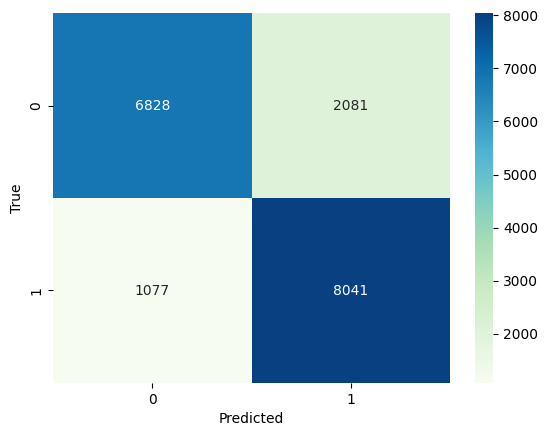

In [ ]:
tabla=confusion_matrix(Y_testeo, y_pred)

sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
accuracy=accuracy_score(Y_testeo,y_pred)
recall=recall_score(Y_testeo,y_pred)
f1=f1_score(Y_testeo,y_pred,)
precision=precision_score(Y_testeo,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8248183280634603
Recall: 0.8818819916648388
Precision: 0.794408219719423
f1 score: 0.8358627858627857


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


### Graficar Arbol

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


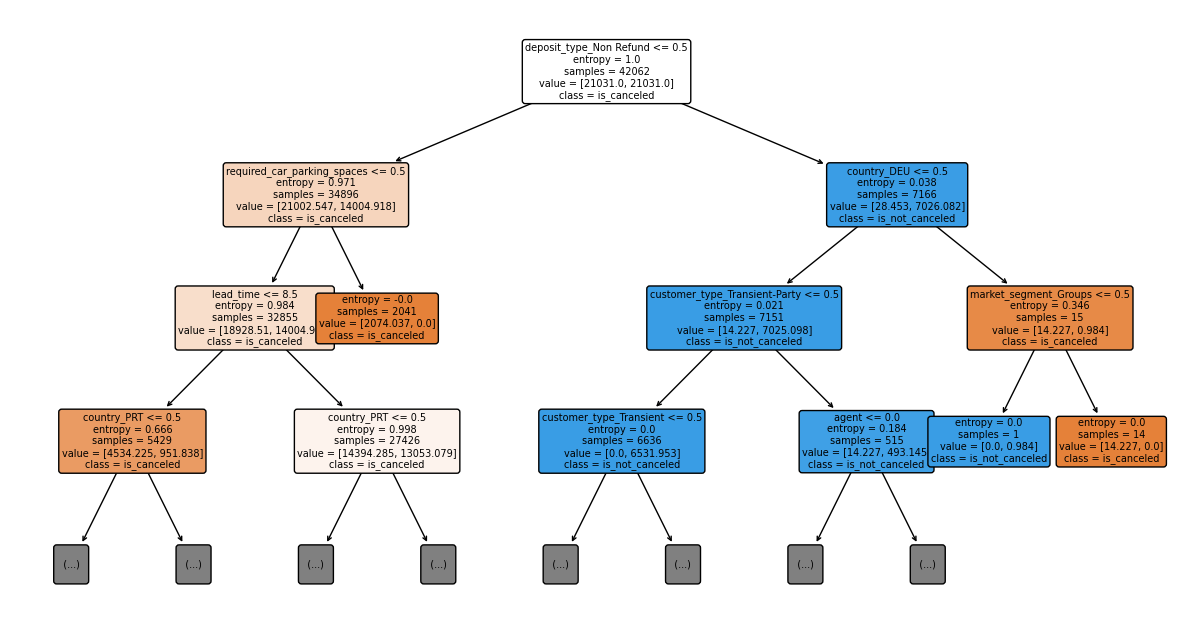

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [ ]:
plt.figure(figsize=(15, 8))

plot_tree(arbol,
          feature_names=X_entrenamiento.columns,
          class_names=['is_canceled', 'is_not_canceled'],
          filled=True,
          rounded=True,
          fontsize=7,
          max_depth=3)

plt.show()

## Kaggle

In [ ]:
ds_testeo.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


(18027, 204)

In [ ]:
ds_entrenamiento_kaggle = ds_training.copy(deep=True)
X_entrenar_kaggle = ds_entrenamiento_kaggle.drop(columns=['id', "is_canceled"], axis=1)
Y_entrenar_kaggle = ds_entrenamiento_kaggle["is_canceled"]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
modelo_kaggle = DecisionTreeClassifier(
    criterion=mejores_hiperparametros['criterion'],
    max_depth=mejores_hiperparametros['max_depth'],
    min_samples_leaf=mejores_hiperparametros['min_samples_leaf'],
    min_samples_split=mejores_hiperparametros['min_samples_split'],
    class_weight=mejores_hiperparametros['class_weight']
)
modelo_prediccion_kaggle = modelo_kaggle.fit(X= X_entrenar_kaggle, y= Y_entrenar_kaggle)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
nombre_archivo = "./modelos/randomSearch.pickle"
pickle.dump(modelo_prediccion_kaggle, open(nombre_archivo, "wb"))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
<ipython-input-34-08361360a61b>:2: ResourceWarning: unclosed file <_io.BufferedWriter name='./modelos/randomSearch.pickle'>


In [ ]:
ds_testing_sinId = ds_testing_sinId.reindex(columns= X_entrenamiento.columns, fill_value=0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
y_pred_kaggle = modelo_kaggle.predict(ds_testing_sinId)
y_pred_kaggle

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


array([1, 1, 0, ..., 1, 1, 0])

In [ ]:
ds_testing_conId.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


(26535, 191)

In [ ]:
ds_submit = pd.DataFrame({'id':ds_testing_conId['id'], 'is_canceled': y_pred_kaggle})
ds_submit.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1


In [ ]:
from pathlib import Path
filepath = Path('submission/modelo_random_tree/submit_random_tree.csv')
ds_submit.to_csv(filepath, index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


## Variante Random Search

In [ ]:
# se deifne la cuadrícula de hiperparámetros a buscar
params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced'],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 20],
    'random_state': [42]
}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
n_iter = 100

n_folds = 10

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Usamos stratified K-Fold

In [ ]:
cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
scorer = make_scorer(f1_score)
random_forest = RandomForestClassifier()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
random_search = RandomizedSearchCV(
    estimator=random_forest,
    param_distributions=params,
    scoring=scorer,
    cv=cv,
    n_iter=n_iter,
    random_state=42,
    verbose=1
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
random_search.fit(X_entrenamiento, Y_entrenamiento)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers a

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'class_weight': [None, 'balanced'],
                                        'max_depth': [None, 10, 20, 30],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'max_leaf_nodes': [None, 10, 20],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'n_estimators': [100, 200, 300],
                                        'random_state': [42]},
                   random_state=42, scoring=make_scorer(f1_score), verbose=1)

In [ ]:
print("Mejores hiperparámetros:")
print(random_search.best_params_)
print("Mejor puntuación F1 Score:", random_search.best_score_)

mejores_hiperparametros = random_search.best_params_

Mejores hiperparámetros:
{'random_state': 42, 'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced'}
Mejor puntuación F1 Score: 0.8810306973369528


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
mejor_random_forest = RandomForestClassifier(**mejores_hiperparametros)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
f1_scores = cross_val_score(mejor_random_forest, X_entrenamiento, Y_entrenamiento, cv=cv, scoring=scorer)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
f1_promedio = np.mean(f1_scores)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
modelo_final = mejor_random_forest.fit(X_entrenamiento, Y_entrenamiento)

y_pred_testeo = modelo_final.predict(X_testeo)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Text(50.722222222222214, 0.5, 'True')

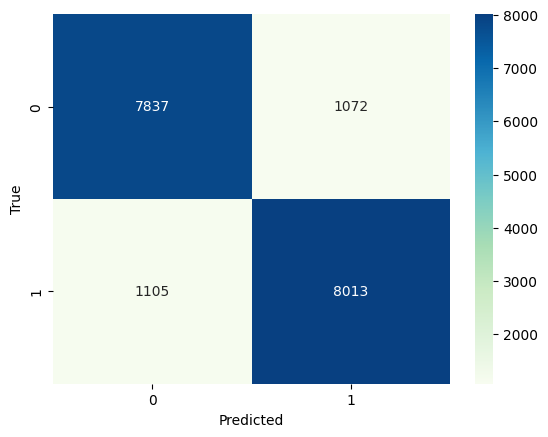

In [ ]:
tabla=confusion_matrix(Y_testeo, y_pred_testeo)

sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
accuracy=accuracy_score(Y_testeo,y_pred_testeo)
recall=recall_score(Y_testeo,y_pred_testeo)
f1=f1_score(Y_testeo,y_pred_testeo,)
precision=precision_score(Y_testeo,y_pred_testeo)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8792367005047984
Recall: 0.8788111427944725
Precision: 0.8820033021463951
f1 score: 0.8804043289567653


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
print("Mejores hiperparámetros encontrados:", mejores_hiperparametros)

Mejores hiperparámetros encontrados: {'random_state': 42, 'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced'}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


### Arbol graficado

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


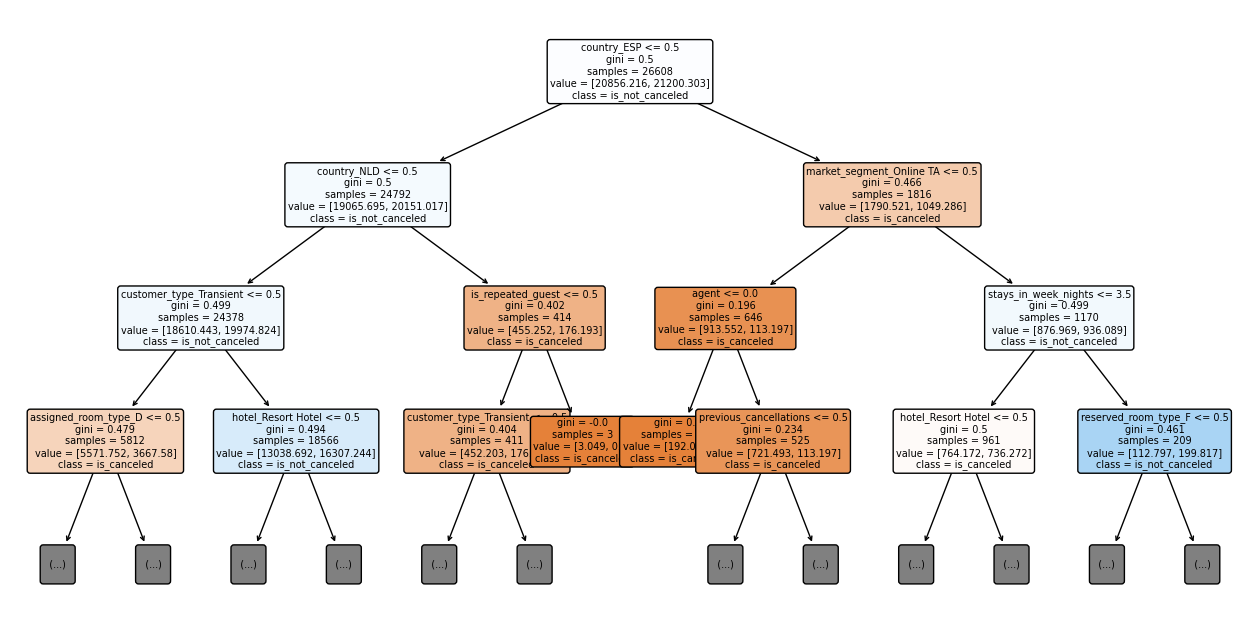

In [ ]:
arbol_individual = modelo_final.estimators_[0]

plt.figure(figsize=(16, 8))
plot_tree(arbol_individual, filled=True, feature_names=X_entrenamiento.columns, class_names=['is_canceled', 'is_not_canceled'], rounded=True, fontsize=7, max_depth = 3)

plt.show()


### Kaggle

In [ ]:
ds_entrenamiento_kaggle = ds_training.copy(deep=True)
X_entrenar_kaggle = ds_entrenamiento_kaggle.drop(columns=['id', 'is_canceled'], axis=1)
Y_entrenar_kaggle = ds_entrenamiento_kaggle['is_canceled']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
arbol_kaggle = RandomForestClassifier(**mejores_hiperparametros)
modelo_prediccion_kaggle = arbol_kaggle.fit(X= X_entrenar_kaggle, y= Y_entrenar_kaggle)
filename = "./modelos/varianteRSArbol.pickle"
pickle.dump(modelo_prediccion_kaggle, open(filename, "wb"))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
<ipython-input-56-5a6d961774b2>:4: ResourceWarning: unclosed file <_io.BufferedWriter name='./modelos/varianteRSArbol.pickle'>


In [ ]:
ds_testing_sinId = ds_testing_sinId.reindex(columns=X_entrenamiento.columns, fill_value=0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
y_pred_kaggle = modelo_prediccion_kaggle.predict(ds_testing_sinId)
y_pred_kaggle

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


array([1, 1, 0, ..., 1, 1, 0])

In [ ]:
ds_submit = pd.DataFrame({'id':ds_testing_conId['id'], 'is_canceled': y_pred_kaggle})
ds_submit.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1


In [ ]:
from pathlib import Path
filepath = Path('submission/modelo_random_tree/submit_random_tree_variante.csv')
ds_submit.to_csv(filepath, index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


## Grid Search

### Hiperparámetros

Ahora utilizamos el método de GridSearch Cross Validation para buscar los hiperparámetros.

In [ ]:
params_grid = {
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': list(range(1, 10)),
    'min_samples_split': list(range(2, 20)),
    'max_depth': list(range(1, 10)),
    'class_weight': [None, 'balanced'],
}

folds = 5

kfoldcv = StratifiedKFold(n_splits=folds)

base_tree = DecisionTreeClassifier()

scorer_fn = make_scorer(f1_score)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
gridcv = GridSearchCV(
    estimator=base_tree,
    param_grid=params_grid,
    scoring=scorer_fn,
    cv=kfoldcv,
    return_train_score=True,
    verbose=1
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
gridcv.fit(X_entrenamiento, Y_entrenamiento)

print("Mejores hiperparámetros:")
print(gridcv.best_params_)
print("Mejor puntuación F1 Score:", gridcv.best_score_)

resultados_grid = gridcv.cv_results_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Fitting 5 folds for each of 5832 candidates, totalling 29160 fits
Mejores hiperparámetros:
{'class_weight': None, 'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 10}
Mejor puntuación F1 Score: 0.8409755663522919


In [ ]:
gridcv.cv_results_['mean_test_score']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


array([0.50032309, 0.50032309, 0.50032309, ..., 0.84034221, 0.84034221,
       0.84024066])

In [ ]:
mejores_hiperparametros_grid = gridcv.best_params_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
arbol_grid = DecisionTreeClassifier(
    criterion=mejores_hiperparametros_grid['criterion'],
    max_depth=mejores_hiperparametros_grid['max_depth'],
    min_samples_leaf=mejores_hiperparametros_grid['min_samples_leaf'],
    min_samples_split=mejores_hiperparametros_grid['min_samples_split'],
    class_weight=mejores_hiperparametros_grid['class_weight']
)

modelo_prediccion_grid = arbol_grid.fit(X = X_entrenamiento, y = Y_entrenamiento)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
y_pred = modelo_prediccion_grid.predict(X_testeo)
y_pred

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


array([1, 1, 0, ..., 0, 1, 0])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Text(50.722222222222214, 0.5, 'True')

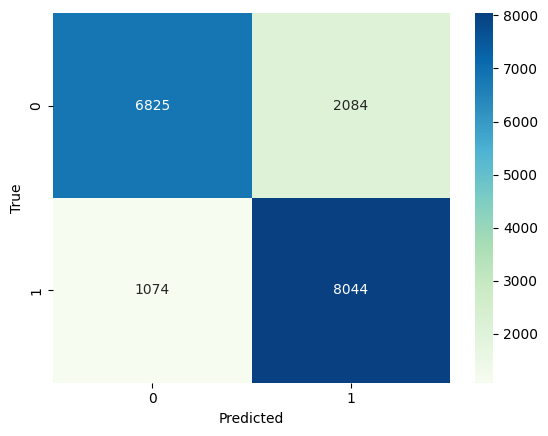

In [ ]:
tabla_grid=confusion_matrix(Y_testeo, y_pred)

sns.heatmap(tabla_grid,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
accuracy=accuracy_score(Y_testeo,y_pred)
recall=recall_score(Y_testeo,y_pred)
f1=f1_score(Y_testeo,y_pred,)
precision=precision_score(Y_testeo,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8248183280634603
Recall: 0.8822110111866638
Precision: 0.7942338072669827
f1 score: 0.8359139561467319


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


### Arbol

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


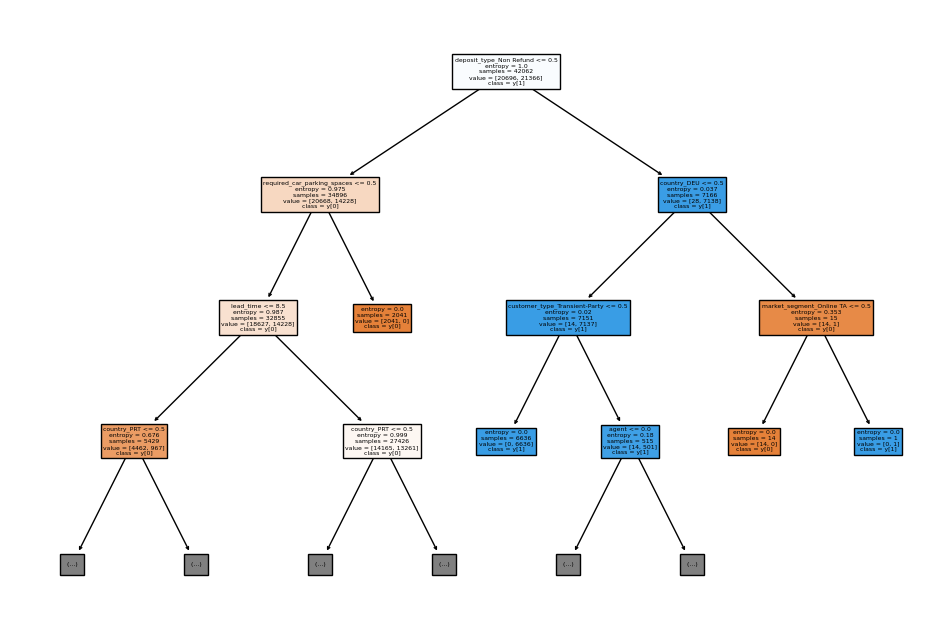

In [ ]:
plt.figure(figsize=(12, 8))
plot_tree(arbol_grid, feature_names=X_entrenamiento.columns, class_names=True, filled=True, max_depth=3)
plt.show()

## Kaggle

In [ ]:
ds_testeo.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


(18027, 204)

In [ ]:
ds_entrenamiento_kaggle = ds_training.copy(deep=True)
X_entrenar_kaggle = ds_entrenamiento_kaggle.drop(columns=['id', "is_canceled"], axis=1)
Y_entrenar_kaggle = ds_entrenamiento_kaggle["is_canceled"]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
modelo_kaggle = DecisionTreeClassifier(
    criterion=mejores_hiperparametros_grid['criterion'],
    max_depth=mejores_hiperparametros_grid['max_depth'],
    min_samples_leaf=mejores_hiperparametros_grid['min_samples_leaf'],
    min_samples_split=mejores_hiperparametros_grid['min_samples_split'],
    class_weight=mejores_hiperparametros_grid['class_weight']
)
modelo_prediccion_kaggle = modelo_kaggle.fit(X= X_entrenar_kaggle, y= Y_entrenar_kaggle)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
nombre_archivo = "./modelos/gridSearch.pickle"
pickle.dump(modelo_prediccion_kaggle, open(nombre_archivo, "wb"))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
<ipython-input-74-7bb0ca8978e5>:2: ResourceWarning: unclosed file <_io.BufferedWriter name='./modelos/gridSearch.pickle'>


In [ ]:
ds_testing_sinId = ds_testing_sinId.reindex(columns= X_entrenamiento.columns, fill_value=0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
y_pred_kaggle = modelo_prediccion_kaggle.predict(ds_testing_sinId)
y_pred_kaggle

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


array([1, 1, 0, ..., 1, 1, 0])

In [ ]:
ds_testing_conId.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


(26535, 191)

In [ ]:
ds_submit = pd.DataFrame({'id':ds_testing_conId['id'], 'is_canceled': y_pred_kaggle})
ds_submit.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1


In [ ]:
from pathlib import Path
filepath = Path('submission/modelo_grid_tree/submit_grid_tree.csv')
ds_submit.to_csv(filepath, index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
